In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D,Dropout, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.utils.layer_utils import get_source_inputs
import warnings
from keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from keras import layers
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!gdown 1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51

Downloading...
From: https://drive.google.com/uc?id=1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51
To: /content/fer2013.zip
100% 63.3M/63.3M [00:01<00:00, 57.9MB/s]


In [4]:
!gdown 1zx1QEIntjTB1GgvyEeSOPbfB8EE8AkK5

Downloading...
From: https://drive.google.com/uc?id=1zx1QEIntjTB1GgvyEeSOPbfB8EE8AkK5
To: /content/Resnet_CW_model.h5
100% 196M/196M [00:02<00:00, 68.3MB/s]


In [5]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
train_dir = "./data/train/" # Directory containing the training data
test_dir = "./data/test/"  # Directory containing the validation data

In [4]:
#get train, val and test datasets
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        # validation_split = 0.2,  
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10,
        # preprocessing_function= resize_for_transferLearning
        )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.5
                                  )

In [5]:
BATCH_SIZE = 128
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (197, 197),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    # subset = "training"  ,            # Uses the training subset of the data
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (197, 197),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation",           # Uses the training subset of the data
    shuffle=True
    )
test_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (197, 197),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "rgb",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training",           # Uses the training subset of the data
    shuffle=True
    )

Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.


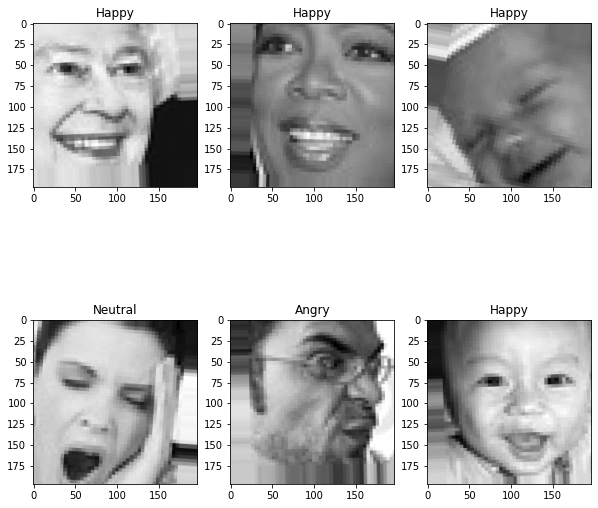

In [6]:
import random
import matplotlib.pyplot as plt
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
img , label = train_generator.__next__()
subPlot =1
plt.figure(figsize=(10,10))
for j in range(1,7):
    i = random.randint(0,(img.shape[0]-1))
    image = img[i]
    labl = class_labels[label[i].argmax()]
    plt.subplot(2,3,subPlot)
    subPlot+=1
    plt.imshow(image[:,:,0], cmap="gray")
    plt.title(labl)
plt.show()

In [7]:
from keras.models import load_model
model = load_model('Resnet_CW_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 197, 197, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 99, 99, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 99, 99, 64)   256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 64)   0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [11]:
from sklearn.utils import class_weight
import numpy as np
Y = validation_generator.classes
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(Y), y= Y)
class_weights_dict = {i: cw for i,cw in enumerate(class_weights)}
class_weights_dict

{0: 1.0697882493289592,
 1: 9.316883116883117,
 2: 1.0008370535714286,
 3: 0.5777097761314222,
 4: 0.8318645640074211,
 5: 0.8225177711534052,
 6: 1.2347676419965576}

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shutil

# shutil.rmtree('./logs')
checkpoint_callback = ModelCheckpoint(
    filepath='./drive/MyDrive/Resnet_CW_model.h5',
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=False,
    mode='max',
    verbose=1,
)
lrd = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.00001)

es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=20)

tb_callback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

history = model.fit(
    train_generator,
    steps_per_epoch=28709 // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=3509 // BATCH_SIZE,
    callbacks=[checkpoint_callback,lrd,tb_callback],
    class_weight= class_weights_dict
)

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 0.7289 - accuracy: 0.6977
Epoch 1: saving model to ./drive/MyDrive/Resnet_CW_model.h5
224/224 [==============================] - 351s 1s/step - loss: 0.7289 - accuracy: 0.6977 - val_loss: 0.8549 - val_accuracy: 0.6927 - lr: 0.0100
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.6966
Epoch 2: saving model to ./drive/MyDrive/Resnet_CW_model.h5
224/224 [==============================] - 336s 1s/step - loss: 0.7367 - accuracy: 0.6966 - val_loss: 0.8733 - val_accuracy: 0.6904 - lr: 0.0100
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 0.7243 - accuracy: 0.7002
Epoch 3: saving model to ./drive/MyDrive/Resnet_CW_model.h5
224/224 [==============================] - 339s 2s/step - loss: 0.7243 - accuracy: 0.7002 - val_loss: 0.8548 - val_accuracy: 0.6936 - lr: 0.0100
Epoch 4/50
224/224 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.6995
E

In [8]:
from keras.models import load_model
model = load_model('Resnet_CW_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 197, 197, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 99, 99, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 99, 99, 64)   256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 64)   0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [10]:
import numpy as np
def getValues(filename, lossType):
    
    with open(filename, 'r',encoding="utf8") as file:
        content = file.read()
        words = content.split()
        l = []
        for i in range(len(words)):
            if words[i] == lossType:
                try:
                    loss_number = float(words[i+1])
                    l.append(loss_number)
                except ValueError:
                    print(f"Invalid number format after 'loss:' at position {i+1}.")
                    return None
        return l
    

train_acc = np.array(getValues('acc_WC.txt','accuracy:'))
train_acc = np.unique(train_acc)
val_acc = np.array(getValues('acc_WC.txt','val_accuracy:'))
train_loss = np.array(getValues('acc_WC.txt','loss:'))
train_loss = np.unique(train_loss)

val_loss = np.array(getValues('acc_WC.txt','val_loss:'))

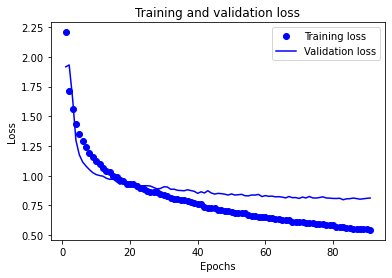

In [11]:
import matplotlib.pyplot as plt

train_loss = np.flip(train_loss)
val_loss = val_loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

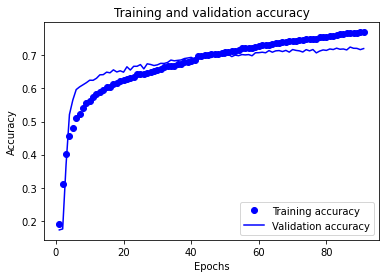

In [12]:
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
val_loss, val_acc   = model.evaluate(validation_generator)
test_loss, test_acc   = model.evaluate(test_generator)
print("test accuracy = {:.2f}".format(test_acc*100))
print("validation accuracy = {:.2f}".format(val_acc*100))

29/29 [==============================] - 10s 342ms/step - loss: 0.9082 - accuracy: 0.6770
test accuracy = 67.70
validation accuracy = 68.97
